# Velocity vector projection by GraphVelo or cosine kernel

Comparison of different projection method:
1. cosine kernel
2. TSP w/ cosine regulation
3. TSP

Benchmark:
1. Ground Truth
2. Ground Truth w/ noise in velocity

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import dynamo as dyn
import scipy.sparse as sp
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from graph_velocity import GraphVelo
from tangent_space import corr_kernel, density_corrected_transition_matrix

In [2]:
def fit_cos_kernel(adata, ekey='X_raw', vkey='rna_velocity', add_prefix=None):
    X = adata.layers[ekey]
    V = adata.layers[vkey]
    X = X.A if sp.issparse(X) else X
    V = V.A if sp.issparse(V) else V
    P = corr_kernel(X, V, adata.uns['neighbors']['indices'])
    P_dc = density_corrected_transition_matrix(P).A
    gvf = dyn.tl.GraphVectorField(P_dc)
    if add_prefix is None:
        adata.layers['velocity_cos'] = gvf.project_velocity(X)
        adata.obsm['cos_pca'] = gvf.project_velocity(adata.obsm['X_pca'])
        adata.obsm['cos_dr'] = gvf.project_velocity(adata.obsm['X_dr'])
        adata.obsm['cos_umap'] = gvf.project_velocity(adata.obsm['X_umap'])
    else:
        adata.layers[f'velocity_{add_prefix}'] = gvf.project_velocity(X)
        adata.obsm[f'{add_prefix}_pca'] = gvf.project_velocity(adata.obsm['X_pca'])
        adata.obsm[f'{add_prefix}_dr'] = gvf.project_velocity(adata.obsm['X_dr'])
        adata.obsm[f'{add_prefix}_umap'] = gvf.project_velocity(adata.obsm['X_umap'])

def fit_graphvelo(adata, ekey='X_raw', vkey='rna_velocity', add_prefix=None, **kwargs):
    gv = GraphVelo(adata, xkey=ekey, vkey=vkey, approx=False)
    gv.train(**kwargs)
    if add_prefix is None:
        adata.layers['velocity_gv'] = gv.project_velocity(adata.layers[ekey])
        adata.obsm['gv_pca'] = gv.project_velocity(adata.obsm['X_pca'])
        adata.obsm['gv_dr'] = gv.project_velocity(adata.obsm['X_dr'])
        adata.obsm['gv_umap'] = gv.project_velocity(adata.obsm['X_umap'])
    else:
        adata.layers[f'velocity_{add_prefix}'] = gv.project_velocity(adata.layers[ekey])
        adata.obsm[f'{add_prefix}_pca'] = gv.project_velocity(adata.obsm['X_pca'])
        adata.obsm[f'{add_prefix}_dr'] = gv.project_velocity(adata.obsm['X_dr'])
        adata.obsm[f'{add_prefix}_umap'] = gv.project_velocity(adata.obsm['X_umap'])

In [3]:
structure = 'cycle'
adata = dyn.read(f'../../data/dyngen/{structure}.h5ad')
adata.layers['spliced'] = adata.layers['counts_spliced']
adata.layers['unspliced'] = adata.layers['counts_unspliced']
adata.layers['X_raw'] = adata.X
adata.layers['X_log'] = adata.layers['logcounts']
adata.obsm['X_dr'] = adata.obsm['dimred']
adata

AnnData object with n_obs × n_vars = 1000 × 100
    obs: 'step_ix', 'simulation_i', 'sim_time'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
    uns: 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions'
    obsm: 'dimred', 'X_dr'
    layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts', 'rna_velocity', 'spliced', 'unspliced', 'X_raw', 'X_log'

In [4]:
dyn.pp.pca(adata, X_data=adata.layers['X_log'], layer='log')
dyn.tl.neighbors(adata, n_neighbors=100)
tmp = adata.copy()
dyn.tl.reduceDimension(tmp)
adata.obsm['X_umap'] = tmp.obsm['X_umap']

|-----> <insert> X_pca to obsm in AnnData Object.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [3.9801s]


In [5]:
vkey='rna_velocity'

In [6]:
fit_graphvelo(adata, ekey='X_raw', vkey=vkey, b=0, add_prefix='gv_'+vkey)
fit_graphvelo(adata, ekey='X_raw', vkey=vkey, add_prefix='gwc_'+vkey)
fit_cos_kernel(adata, ekey='X_raw', vkey=vkey, add_prefix='cos_'+vkey)

Learning Phi in tangent space projection.: 100%|██████████| 1000/1000 [00:09<00:00, 107.81it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1000/1000 [00:02<00:00, 466.58it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1000/1000 [00:00<00:00, 11562.93it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1000/1000 [00:00<00:00, 7764.22it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1000/1000 [00:00<00:00, 14083.12it/s]
Learning Phi in tangent space projection.: 100%|██████████| 1000/1000 [00:04<00:00, 238.54it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1000/1000 [00:02<00:00, 348.38it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1000/1000 [00:00<00:00, 7654.44it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1000/1000 [00:00<00:00, 8549.65it/s]
projecting velocity vector to l

|-----> Neither edge weight nor length matrix is provided. Inferring adjacency matrix from `F`.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [3.7543s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.3227s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1028s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1263s]


In [7]:
def add_significance(ax, left: int, right: int, significance: str, level: int = 0, max_y = None, **kwargs):
    bracket_level = kwargs.pop("bracket_level", 0.8)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.005)
    
    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom if max_y is None else max_y - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot(
        [left, left, right, right],
        [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs
    )
    
    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha='center',
        va='bottom',
        c='k'
    )

def get_significance(pvalue):
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

In [8]:
def cosine(x, y):
    return np.inner(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
def residual(x, y):
    return np.linalg.norm(x - y)

In [9]:
def get_significance(pvalue):
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

In [10]:
def get_classification_scores(velo_pred, velo_true, score_func, **kwargs):
    n_var = velo_true.shape[1]
    velo_pred[np.isnan(velo_pred)] = 0
    velo_true[np.isnan(velo_true)] = 0
    gv_score = [score_func(velo_pred[:, var_id], velo_true[:, var_id], **kwargs) for var_id in range(n_var)]
    return gv_score

In [11]:
def permute_rows_nsign(A: np.ndarray, seed=0) -> None:
    """Permute the entries and randomly switch the sign for each row of a matrix independently.
    The function is adapted from velocyto.
    Args:
        A: A numpy array that will be permuted.
    """
    np.random.seed(seed)
    plmi = np.array([+1, -1])
    A_ = A.copy()
    for i in range(A_.shape[1]):
        np.random.shuffle(A_[:, i])
        A_[:, i] = A_[:, i] * np.random.choice(plmi, size=A_.shape[0])
    return A_

In [12]:
adata.layers['velocity_rnd'] = permute_rows_nsign(adata.layers['rna_velocity'].A)

In [13]:
palette = {"GraphVelo": "#f15a24", "GraphVelo w/ cosine": "#459e97", "cosine kernel": "#ab99e7", "random": "lightgrey"}

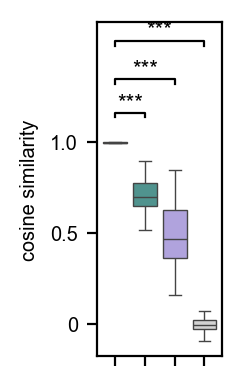

In [14]:
rnd_score = get_classification_scores(
    velo_true=adata.layers['rna_velocity'].A,
    velo_pred=adata.layers[f'velocity_rnd'],
    score_func=cosine,
)
cos_score = get_classification_scores(
    velo_true=adata.layers['rna_velocity'].A,
    velo_pred=adata.layers[f'velocity_cos_{vkey}'],
    score_func=cosine,
)
gwc_score = get_classification_scores(
    velo_true=adata.layers['rna_velocity'].A,
    velo_pred=adata.layers[f'velocity_gwc_{vkey}'].A,
    score_func=cosine,
)
gv_score = get_classification_scores(
    velo_true=adata.layers['rna_velocity'].A,
    velo_pred=adata.layers[f'velocity_gv_{vkey}'].A,
    score_func=cosine,
)
df = pd.DataFrame(
    {
        "cosine similarity":  gv_score + gwc_score + cos_score + rnd_score,
        "Model":  ["GraphVelo"] * adata.n_vars + ["GraphVelo w/ cosine"] * adata.n_vars + ["cosine kernel"] * adata.n_vars + ["random"] * adata.n_vars
    }
)
fig, ax = plt.subplots(figsize=(0.8, 2.2))

sns.boxplot(data=df, x="Model", y="cosine similarity", palette=palette, ax=ax, linewidth=0.5, showfliers=False)


ttest_res = ttest_ind(gv_score, gwc_score, equal_var=False, alternative="greater")
significance = get_significance(ttest_res.pvalue)
add_significance(ax=ax, left=0, right=1, significance=significance, lw=0.8, bracket_level=1.1, c="k", level=0)
ttest_res = ttest_ind(gv_score, cos_score, equal_var=False, alternative="greater")
significance = get_significance(ttest_res.pvalue)
add_significance(ax=ax, left=0, right=2, significance=significance, lw=0.8, bracket_level=1.1, c="k", level=0)
ttest_res = ttest_ind(gv_score, rnd_score, equal_var=False, alternative="greater")
significance = get_significance(ttest_res.pvalue)
add_significance(ax=ax, left=0, right=3, significance=significance, lw=0.8, bracket_level=1.1, c="k", level=0)


y_min, y_max = ax.get_ylim()
ax.set_ylim([y_min, y_max + 0.02])

ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels([0, 0.5, 1.0])
ax.set(xlabel=None)
plt.xticks(rotation = 45, ha='right') # Rotates X-Axis Ticks by 45-degrees
ax.set(xlabel="", xticklabels="")
# plt.savefig(dpi=300, transparent=True, fname=f'./figures/{structure}_result/{structure}_cosine_sim.pdf', bbox_inches = "tight")
plt.show()

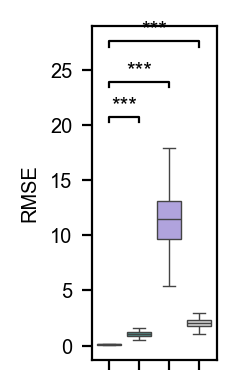

In [15]:
rnd_score = get_classification_scores(
    velo_true=adata.layers['rna_velocity'].A,
    velo_pred=adata.layers[f'velocity_rnd'],
    score_func=mean_squared_error,
    squared=False,
)
cos_score = get_classification_scores(
    velo_true=adata.layers['rna_velocity'].A,
    velo_pred=adata.layers[f'velocity_cos_{vkey}'],
    score_func=mean_squared_error,
    squared=False,
)
gwc_score = get_classification_scores(
    velo_true=adata.layers['rna_velocity'].A,
    velo_pred=adata.layers[f'velocity_gwc_{vkey}'].A,
    score_func=mean_squared_error,
    squared=False,
)
gv_score = get_classification_scores(
    velo_true=adata.layers['rna_velocity'].A,
    velo_pred=adata.layers[f'velocity_gv_{vkey}'].A,
    score_func=mean_squared_error,
    squared=False,
)
df = pd.DataFrame(
    {
        "RMSE":   gv_score + gwc_score + cos_score + rnd_score,
        "Model":  ["GraphVelo"] * adata.n_vars + ["GraphVelo w/ cosine"] * adata.n_vars + ["cosine kernel"] * adata.n_vars + ["random"] * adata.n_vars
    }
)
fig, ax = plt.subplots(figsize=(0.8, 2.2))

sns.boxplot(data=df, x="Model", y="RMSE", palette=palette, ax=ax, linewidth=0.5, showfliers=False)


ttest_res = ttest_ind(gv_score, gwc_score, equal_var=False, alternative="less")
significance = get_significance(ttest_res.pvalue)
add_significance(
    ax=ax, left=0, right=1, significance=significance, lw=0.8, bracket_level=1.1, c="k", level=0
)
ttest_res = ttest_ind(gv_score, cos_score, equal_var=False, alternative="less")
significance = get_significance(ttest_res.pvalue)
add_significance(
    ax=ax, left=0, right=2, significance=significance, lw=0.8, bracket_level=1.1, c="k", level=0
)
ttest_res = ttest_ind(gv_score, rnd_score, equal_var=False, alternative="less")
significance = get_significance(ttest_res.pvalue)
add_significance(
    ax=ax, left=0, right=3, significance=significance, lw=0.8, bracket_level=1.1, c="k", level=0
)

y_min, y_max = ax.get_ylim()
# ax.set_ylim([y_min, 5])

# ax.set_yticks([0, 10, 50])
# ax.set_yticklabels([0, 10, 50])
ax.set(xlabel=None)
plt.xticks(rotation = 45, ha='right') # Rotates X-Axis Ticks by 45-degrees
ax.set(xlabel="", xticklabels="")
# plt.savefig(dpi=300, transparent=True, fname=f'./figures/{structure}_result/{structure}_rmse.pdf', bbox_inches = "tight")
plt.show()

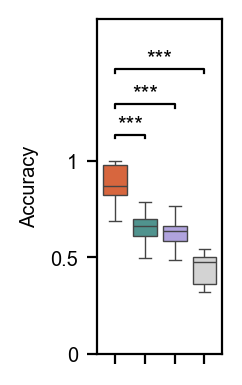

In [16]:
rnd_score = get_classification_scores(
    velo_true=np.sign(adata.layers['rna_velocity'].A),
    velo_pred=np.sign(adata.layers[f'velocity_rnd']),
    score_func=accuracy_score,
)
cos_score = get_classification_scores(
    velo_true=np.sign(np.sign(adata.layers['rna_velocity'].A)),
    velo_pred=np.sign(adata.layers[f'velocity_cos_{vkey}']),
    score_func=accuracy_score,
)
gwc_score = get_classification_scores(
    velo_true=np.sign(adata.layers['rna_velocity'].A),
    velo_pred=np.sign(adata.layers[f'velocity_gwc_{vkey}'].A),
    score_func=accuracy_score,
)
gv_score = get_classification_scores(
    velo_true=np.sign(adata.layers['rna_velocity'].A),
    velo_pred=np.sign(adata.layers[f'velocity_gv_{vkey}'].A),
    score_func=accuracy_score,
)
df = pd.DataFrame(
    {
        "Accuracy":  gv_score + gwc_score + cos_score + rnd_score,
        "Model":  ["GraphVelo"] * adata.n_vars + ["GraphVelo w/ cosine"] * adata.n_vars + ["cosine kernel"] * adata.n_vars + ["random"] * adata.n_vars
    }
)
fig, ax = plt.subplots(figsize=(0.8, 2.2))

sns.boxplot(data=df, x="Model", y="Accuracy", palette=palette, ax=ax, linewidth=0.5, showfliers=False)


ttest_res = ttest_ind(gv_score, gwc_score, equal_var=False, alternative="greater")
significance = get_significance(ttest_res.pvalue)
add_significance(
    ax=ax, left=0, right=1, significance=significance, lw=0.8, bracket_level=1.1, c="k", level=0
)
ttest_res = ttest_ind(gv_score, cos_score, equal_var=False, alternative="greater")
significance = get_significance(ttest_res.pvalue)
add_significance(
    ax=ax, left=0, right=2, significance=significance, lw=0.8, bracket_level=1.1, c="k", level=0
)
ttest_res = ttest_ind(gv_score, rnd_score, equal_var=False, alternative="greater")
significance = get_significance(ttest_res.pvalue)
add_significance(
    ax=ax, left=0, right=3, significance=significance, lw=0.8, bracket_level=1.1, c="k", level=0
)

y_min, y_max = ax.get_ylim()
ax.set_ylim([y_min, y_max+0.2])

ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0, 0.5, 1])
ax.set(xlabel=None)
plt.xticks(rotation = 45, ha='right') # Rotates X-Axis Ticks by 45-degrees
ax.set(xlabel="", xticklabels="")
# plt.savefig(dpi=300, transparent=True, fname=f'./figures/{structure}_result/{structure}_accuracy.pdf', bbox_inches = "tight")
plt.show()